# Monotone operator equilibrium networks

Monotone operator equilibrium networks (MONs) are a form of Deep Equilibrium Model ([Bai et al. 2019](https://arxiv.org/abs/1909.01377)) which guarantee convergence to a unique fixed-point. 

Unlike traditional deep networks which explicitly iterate some number of non-linear layers, deep equilibrium models (DEQs) directly solve for the fixed point of an "infinitely deep" weight-tied, input-injected  network. For example, given nonlinearity $\sigma$, network weights $W, U, b$, and input $x$, the network could take the form
$$z^{k+1} = \sigma(W z^k + U x + b)$$
where $z^k$ are the hidden units at layer $k$. Here $W,U$ could be dense matrices, or they could correspond to more structured linear operators such as convolutions or multi-tiered convolutional operators (see below).
DEQs solve directly for the fixed-point of the iteration
$$z^\star = \sigma(W z^\star + U x + b).$$

But how can we guarantee that such a fixed point exists, is unique, and that our fixed-point solver will converge to it? In practice, DEQs require extensive tuning in order to obtain stable convergence. 

## Fixed-point solving as operator splitting
We recast the problem of finding the network fixed point as a form of _monotone operator splitting problem_, which can be solved using iterative operator splitting methods such as _forward-backward_ or _Peaceman-Rachford_ splitting. For an introduction to monotone operator theory see [this survey](https://web.stanford.edu/~boyd/papers/pdf/monotone_primer.pdf) by Ryu and Boyd or see Appendix A in [our paper](https://arxiv.org/abs/2006.08591) for a very brief overview.

In particular, we show that finding the fixed-point $z^*$ is equivalent to finding a solution to the operator splitting problem $0 \in (X+Y)(z^\star)$ with the operators
\begin{equation}
X(z) = (I - W)(z) - (Ux + b), \;\; Y = \partial f
\end{equation}
so long as $\sigma$ can be represented as $\sigma(\cdot) = \text{prox}^1_f(\cdot)$ for some (convex, closed, proper) function $f$. Many common nonlinearities used in deep networks can be represented as proximal operators; for example, the ReLU nonlinearity $\sigma(x) = [x]_+$ is equal to the proximal operator of the indicator of the positive orthant $f(x) = I\{x \geq 0\}$.

Another question is how to backpropagate the loss through the network fixed point. That is, we need to multiply by $\partial z^\star / \partial (\cdot)$ in order to compute
\begin{equation}
\frac{\partial \ell}{\partial (\cdot) } = \frac{\partial \ell}{\partial z^\star} \frac{\partial z^\star}{\partial (\cdot)}.
\end{equation}
The challenge here is that $z^\star$ is not an explicit function of the inputs. As is the case with DEQs, we can do this analytically using the implicit function theorem. In fact, analytical backpropagation through the fixed point can itself be cast as an operator splitting problem. Implementations of splitting methods applied to both fixed-point solving and backpropagation can be found in [splitting.py](splitting.py).

## Monotone parameterization

The operator splitting methods will be guaranteed to converge to a unique solution provided the network weights obey a certain monotone constraint. We can directly parameterize networks such that this condition holds, by having $W$ take the form
$$W = (1-m)I - A^T A + B - B^T$$
where $m>0$ and there is no constraint on $A$ or $B$.

Implementations for fully-connected, convolutional, and multi-scale convolutional networks can be found in [mon.py](mon.py). 

For fully-connected networks we can directly parameterize $W$ in the above form with $A,B$ being dense matrices (see class `mon.MONSingleFc`). But this can equally well be achieved when $W$ is a convolution (`mon.MONSingleFc`), or consists of multiple tiers of convolutions at different scales (`mon.MONMultiConv`). In this last case we consider $W$ of the form 

\begin{equation} 
W=\left(\begin{array}{ccccc}
W_{11} & 0 & 0 & \cdots & 0\\
W_{21} & W_{22} & 0 & \cdots & 0 \\
0 & W_{32} & W_{33} & \cdots & 0  \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & W_{LL} \end{array} \right)
\end{equation}

where $W_{ii}$ denotes an $n_i$ channel to $n_i$ channel convolution, and $W_{i+1,i}$ denotes an $n_i$ to $n_{i+1}$ channel, *strided* convolution. Correspondingly, the hidden states have the structured form

\begin{equation}
z=\left(\begin{array}{c} z_1\\
z_2\\
\vdots \\
z_L 
\end{array} \right)
\end{equation}

where $z_i$ denotes the hidden units at level $i$. In this case, to ensure that the monotone constraint is met, we need to correctly parameterize each of the $W_{ij}$. It works out that the $W_{ii}$ convolutions will have the form
$$W_{ii} = (1-m)I - A_{ii}^T A_{ii} - A_{i+1,i}^T A_{i+1,i} + B_{ii} - B_{ii}^T$$
and for the final tier $L$
$$W_{LL} = (1-m)I - A_{LL}^T A_{LL} + B_{LL} - B_{LL}^T$$
and the subdiagonal convolutions will have the form
$$W_{i+1,i} = -2 A_{i+1,i+1}^T A_{i+1,i}.$$

The modules such as `mon.MONMultiConv` encapsulate the linear part of the network. That is, the forward method of the modules compute $h = Wz + Ux + b$, where $x$ is a minibatch of examples, and $z$ is an initial set of hidden states. Here is an example of the multi-tier convolutional model in use. Note that $h$ will be a set of hidden units $h_i$ of the same shapes as the $z_i$:

In [1]:
import mon
import torch

linear_module = mon.MONMultiConv(in_channels=3, conv_channels=(8,16,32), 
                         image_size=34, kernel_size=3, m=1.0)


#The module knows the correct shape for it's hidden states z_i at each tier for a given batch size
n_batch = 4
z_shapes = linear_module.z_shape(n_batch=n_batch)

print("shapes of the z_i:\t", 
      {"z_{}".format(i+1):list(z_i_shape) for i,z_i_shape in enumerate(z_shapes)})

z = tuple(torch.randn(*s) for s in z_shapes)
x = torch.randn(n_batch,3,34,34)

#run the forward method of the module
h = linear_module(x, *z) 

print("shapes of the h_i:\t", 
      {"h_{}".format(i+1):list(h_i.shape) for i,h_i in enumerate(h)})

shapes of the z_i:	 {'z_1': [4, 8, 34, 34], 'z_2': [4, 16, 18, 18], 'z_3': [4, 32, 10, 10]}
shapes of the h_i:	 {'h_1': [4, 8, 34, 34], 'h_2': [4, 16, 18, 18], 'h_3': [4, 32, 10, 10]}


The operator splitting methods will also need to be able to perform the multiplications $Wz$ and $W^Tz$, which in the multi-tier case involves applying different convolutions to the different $z_i$. Here we test the implementations of the multiplication and transposed multiplication by computing $y^TWz$ two ways:

In [2]:
y = tuple(torch.randn(*s) for s in linear_module.z_shape(n_batch))
z = tuple(torch.randn(*s) for s in linear_module.z_shape(n_batch))

#compute Wz using linear_module.multiply
Wz = linear_module.multiply(*z)

#compute yT(Wz)
yTWz = tuple(yi * Wzi for yi, Wzi in zip(y,Wz))
u = sum([t.sum() for t in yTWz])

#compute WTy using linear_module.multiply_transpose  
WTy = linear_module.multiply_transpose(*y)

#compute zT(WTy)
zTWTy = tuple(zi * WTyi for zi, WTyi in zip(z,WTy))
v = sum([t.sum() for t in zTWTy])

#assert equal
print(((u-v).abs()/v.abs() < 1e-5).item())

True


## Inversion

Some splitting methods (e.g. Peaceman-Rachford which we use for our experiments) also require multiplying by the inverse $V := (I + \alpha(I - W))^{-1}$ and by the inverse transpose $V^T$. How can we achieve this when $W$ has this multi-tier form? As we show in the paper, we can efficiently multiply by the inverse of the convolutions in the frequency domain, by computing the FFT of kernels and the $z_i$. Because this multiplication will occur for each iteration of Peaceman-Rachford, we can precompute the kernel inverses in FFT space. Here we verify the behavior of the inverse and inverse transpose multiplications:

In [3]:
#initialize the inverse (alpha*I + beta*W)^-1 in frequency domain
alpha, beta = 2.0, -0.5
linear_module.init_inverse(alpha, beta)

z = tuple(torch.randn(*s) for s in linear_module.z_shape(n_batch))

#verify inverse
h = linear_module.multiply(*z)
#multiplies by inverse by computing the FFTs of the z_i
z_inv = linear_module.inverse(*tuple(beta * h_i + alpha * z_i for h_i, z_i in zip(h,z)))
print("\tinverse undoes multiply : \t\t\t", 
      [(z_i-z_inv_i).norm().item()/z_inv_i.norm().item() < 1e-5 for z_i, z_inv_i in zip(z,z_inv)])

# verify inverse transpose
h = linear_module.multiply_transpose(*z)
z_inv = linear_module.inverse_transpose(*tuple(beta * h_i + alpha * z_i for h_i, z_i in zip(h,z)))
print("\tinverse transpose undoes multiply transpose:\t", 
      [(z_i-z_inv_i).norm().item()/z_inv_i.norm().item() < 1e-5 for z_i, z_inv_i in zip(z,z_inv)])

	inverse undoes multiply : 			 [True, True, True]
	inverse transpose undoes multiply transpose:	 [True, True, True]


## Nonlinearity

Now we need to implement the nonlinear portion of the network, the function $\sigma$. As mentioned, the ReLU operator meets our requirements as it can be represented as a prox operator, and we use it throughout. The modules `mon.MONReLU` or `mon.MONBorderReLU` work with single- or multi-tier MONs by applying the ReLU to each tier individually. The `mon.MONBorderReLU` module zeros out the boarder of each $z_i$, which takes care of a detail we have not yet mentioned: inverting a convolution via the FFT requires that the convolution be circular. To negate the effect of the circular convolution, we zero-pad the input and then enforce the padding after the convolution by zeroing out the border in the ReLU.

## Operator splitting methods

As mentioned, both solving for the network fixed-point as well as backpropagate through the fixed point can be formulated as different operator splitting problems, each of which we can solve using either Peacman-Rachform or forward-backward iterative methods. The details of the iteration for each of the problems and methods is given in the paper. For the purposes of this tutorial we will treat these as black-box modules which simply wrap our linear and nonlinear modules. The forward method of the modules solves a splitting problem in order to find the fixed point, while the backward method solves a splitting problem in order to backpropagate the gradient of the loss.

The splitting methods are implemented in the modules `splitting.MONForwardBackwardSplitting` and `splitting.MONPeacemanRachford`. We can specify the error tolerance `tol`, the maximum number of iterations `max_iter`, and the parameter `alpha` which is used in defining the operators and affects the convergence rate of the splitting methods. While Peaceman-Rachford will converge for any $\alpha>0$, forward-backward will only converge for small enough $\alpha$ (see paper for details). 

Example usage:

In [4]:
import splitting as sp

linear_module = mon.MONMultiConv(in_channels=3, conv_channels=(8,16,32), 
                         image_size=34, kernel_size=3, m=1.0)
nonlinear_module = mon.MONBorderReLU(border=1)

solver = sp.MONPeacemanRachford(linear_module, 
                                nonlinear_module,
                                alpha=1.0,
                                tol=1e-2,
                                max_iter=50)
# calling the forward method on the input x
out = solver(x)
print('\tForward')
for i, err in enumerate(solver.errs):
    print('\t\titer {}: err {}'.format(i+1, err))

# calling the backward method on the input x by backpropagating
l = out[0].sum()
l.backward()
print('\tBackward')
for i, err in enumerate(solver.errs):
    print('\t\titer {}: err {}'.format(i+1, err))

	Forward
	Backward
		iter 1: err 0.9999999923644094
		iter 2: err 0.5263211588851346
		iter 3: err 0.17355014188388368
		iter 4: err 0.04143056592429041
		iter 5: err 0.011709021576873221
		iter 6: err 0.002919624955046819


## Training

The MON consists of the linear and nonlinear modules wrapped in a splitting method solver. For our classification experiments we pass the output of the MON through a final dense layer which outputs logits. The full models which do this are implemented in `train.SingleFcNet`, `train.SingleConvNet`, and `train.MultiConvNet`.

The [train.py](train.py) file also contains data loaders for MNIST, SVHN, and CIFAR-10, as well the main training loop. For example usage see [experiments.ipynb](experiments.ipynb). Here we train a small, fully connected model for a single epoch on MNIST. Note that we adjust $\alpha$ throughout training to minimize the required solver iterations.

In [5]:
import train

trainLoader, testLoader = train.mnist_loaders(train_batch_size=128, test_batch_size=400)

model = train.SingleFcNet(sp.MONPeacemanRachford,
                        in_dim=28**2,
                        out_dim=20,
                        alpha=1.0,
                        max_iter=300,
                        tol=1e-2,
                        m=1.0) #parameter which controls the strong monotonicity of W

train.train(trainLoader, testLoader,
        model,
        max_lr=1e-3,
        lr_mode='step',  #use step decay learning rate
        step=10,      
        change_mo=False, #do not adjust momentum during training
        epochs=1,
        print_freq=100,
        tune_alpha=True)

----tuning alpha----
current:  1.0
alpha: 1.0	 iters: 6
alpha: 0.5	 iters: 5
alpha: 0.25	 iters: 8
setting to:  0.5
--------------

Train Epoch: 0.21 [12928/60000 (21%)]	Loss: 0.5153	Error: 20.31
Fwd iters: 5.00	Fwd Time: 0.0019	Bkwd Iters: 6.00	Bkwd Time: 0.0021

Train Epoch: 0.43 [25728/60000 (43%)]	Loss: 0.3055	Error: 10.16
Fwd iters: 5.00	Fwd Time: 0.0019	Bkwd Iters: 6.00	Bkwd Time: 0.0021

----tuning alpha----
current:  0.5
alpha: 1.0	 iters: 6
alpha: 0.5	 iters: 5
alpha: 0.25	 iters: 8
setting to:  0.5
--------------

Train Epoch: 0.64 [38528/60000 (64%)]	Loss: 0.4320	Error: 10.94
Fwd iters: 5.00	Fwd Time: 0.0018	Bkwd Iters: 6.00	Bkwd Time: 0.0021

Train Epoch: 0.85 [51328/60000 (85%)]	Loss: 0.1962	Error: 7.03
Fwd iters: 5.00	Fwd Time: 0.0020	Bkwd Iters: 6.00	Bkwd Time: 0.0023

Tot train time: 10.442179203033447


Test set: Average loss: 0.2634, Error: 798/10000 (7.98%)
Tot test time: 1.2854909896850586






## Results on image benchmarks

MONs perform well on several image classification benchmarks. For example, the table shows performance of several instantiations of MON on CIFAR-10. We compare to the performance of Neural ODEs ([Chen et al. 2018](https://arxiv.org/abs/1806.07366)) and Augmented Neural ODEs ([Dupont et al. 2019](https://arxiv.org/abs/1904.01681)), the only other implicit-depth models like MON which guarantee existence of a network fixed-point.   
 
| Method                 | Model size | Acc.       |
|---------------------------------------|------------------------|---------------------------|
| Neural ODE             | 172K                   | 53.7%                  |
| Aug. Neural ODE | 172K                   | 60.6%                  |
| MON (ours\)                    |                        |                           |
| ---Single conv.           | 172K                   | **74.1%**      |
| ---Multi-tier           | 170K                   | 71.8%                  |
| ---Single conv. lg with data aug. | 854K                   | 82.5%             |
| ---Multi-tier lg with data aug. | 1M                     | **89.7%** |

The code to train these models and all those described in the results section of the paper is given in [`experiments.ipynb`](experiments.ipynb).

## Convergence of operator splitting methods

We can test the convergence rates of the operator splitting methods on a fully trained model. We load a fully connected network trained on MNIST and test convergence of forward-backward and Peaceman-Rachford splitting for a range of $\alpha$ values. Note that in this case, for $\alpha > 0.125$ forward-backward doesn't converge. Peaceman-Rachford is guaranteed to converge for any $\alpha>0$, and is more efficent than forward-backward for the correct choice of $\alpha$.

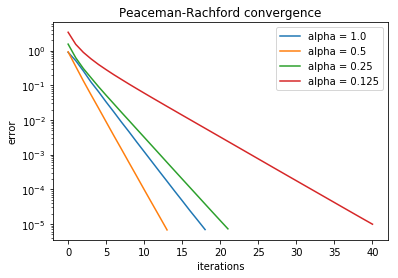

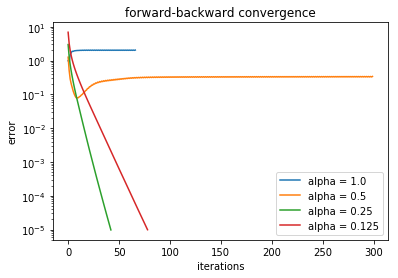

In [6]:
import utils
from matplotlib import pyplot  as plt
%matplotlib inline


# test Peaceman-Rachford convergence for range of alpha values
trainLoader, testLoader = train.mnist_loaders(train_batch_size=128, test_batch_size=400)
for alpha in [1.0, 0.5, 0.25, 0.125]:
    model = train.SingleFcNet(sp.MONPeacemanRachford,
                            in_dim=28**2,
                            out_dim=87,
                            alpha=alpha,
                            max_iter=300,
                            tol=1e-5,
                            m=1.0)

    model.load_state_dict(torch.load("mnist_fc_model_trained.pt", map_location=torch.device('cpu')))

    errs = utils.get_splitting_stats(testLoader,model)
    plt.semilogy(errs, label="alpha = {}".format(alpha))
plt.ylabel("error")
plt.xlabel("iterations")
plt.title('Peaceman-Rachford convergence')
plt.legend()
plt.show()

# test forward-backward convergence for range of alpha values
trainLoader, testLoader = train.mnist_loaders(train_batch_size=128, test_batch_size=400)

for alpha in [1.0, 0.5, 0.25, 0.125]:
    model = train.SingleFcNet(sp.MONForwardBackwardSplitting,
                            in_dim=28**2,
                            out_dim=87,
                            alpha=alpha,
                            max_iter=300,
                            tol=1e-5,
                            m=1.0)

    model.load_state_dict(torch.load("mnist_fc_model_trained.pt", map_location=torch.device('cpu')))

    errs = utils.get_splitting_stats(testLoader,model)
    plt.semilogy(errs, label="alpha = {}".format(alpha))
plt.ylabel("error")
plt.xlabel("iterations")
plt.title('forward-backward convergence')
plt.legend()
plt.show()